In [1]:
import mpmath as mp
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from mpmath import *
from mpl_toolkits.mplot3d import Axes3D
mp.dps = 15; mp.pretty = True
from numba import jit

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#tf.__version__

# Custom activation function
#from keras.layers import Activation
#from keras import backend as K
#from keras.utils.generic_utils import get_custom_objects

!conda list scikit-learn

# packages in environment at /Users/minwookim/opt/anaconda3:
#
# Name                    Version                   Build  Channel
scikit-learn              1.1.1                    pypi_0    pypi


In [3]:
# Normalise X value with choosen range
def xnorm (x,maxrange,minrange):
    # Separate the dimensions
    n=[]
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        rex=(maxrange-minrange)/(np.max(temp)-np.min(temp))*(np.array(temp)-np.min(temp))+minrange
        n.append(rex)
    a=[]
    for i in range(x.shape[0]):
        r=[]
        for j in range(x.shape[1]):
            r.append(n[j][i])
        a.append(r)
    return np.array(a)

# Normalise Y value with choosen range
def ynorm (func,maxrange,minrange):
    rex=(maxrange-minrange)/(np.max(func)-np.min(func))*(np.array(func)-np.min(func))+minrange
    return rex

# Decode Normalised integrated value
def decode(func,x,maxrange,minrange,inte):
    v={}
    for j in range(x.shape[1]):
        temp=[]
        for i in range(x.shape[0]):
            temp.append(x[i][j])
        v[j]=np.max(temp)-np.min(temp)
    product=1
    for i in range(x.shape[1]):
        product=product*v[i]
    vs=product
    vss=(maxrange-minrange)**x.shape[1]
    f=np.max(func)-np.min(func)
    yy=maxrange-minrange
    return vs*f*inte/(vss*yy)+(np.min(func)-f/yy*minrange)*vs

# Initial function
def init(dim):
    # number of function dimension
    dim = dim
    # training set of N
    N = 3000*dim**3
    # random x grid
    x = np.random.random((N,dim))
    # set the maximum dimension
    MAX_DIM=20
    # set the random variables of u and c
    np.random
    u = np.random.random((dim,))
    cs = np.random.random((MAX_DIM,))
    cs = cs[:x.shape[1]]
    return dim, N, x, u, cs

# function for fitting
# y value
def oscil(x):
    arg = np.dot(x,cs)
    arg += u[0] * 2 * np.pi
    return np.cos(arg)

def prod(x):
    temp={}
    for i in range(x.shape[1]):
        temp2=[]
        for j in range(x.shape[0]):
            temp2.append(x[j][i])
        temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
    product=1
    for i in range(x.shape[1]):
        product=product*temp[i]
    return product

# function graph
def graph(dim,x,y):
    if dim == 1:
        plt.scatter(x,y)
        plt.show()
    elif dim == 2:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1=[j[0] for j in x]
        x2=[j[1] for j in x]
        ax.scatter(x1, x2, y)
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        img = ax.scatter(x1, x2, x3, c=y, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
    elif dim == 4:
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')
        x1 = [j[0] for j in x]
        x2 = [j[1] for j in x]
        x3 = [j[2] for j in x]
        x4 = [j[3]*30 for j in x]
        img = ax.scatter(x1, x2, x3, c=y,s=x4, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()

# number of nodes (k) tunable parameter k1,k2
def node(dim,N):
    k1 = 4.33
    k2 = 16
    #k = math.floor(((np.log10(N)**(-k1))*(k2*N/(dim+2))))
    k = math.floor(10*dim*np.log10(N)**1.5)
    return k

# weight and bias of input and output
def sk_coe(mlpr):
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(dim):
        weight_input.append(mlpr.coefs_[0][i])
    return weight_input, weight_output, bias_input, bias_output

def tf_coe(mlpr):
    weight_input = []
    weight_output = mlpr.layers[1].get_weights()[0]
    bias_input = mlpr.layers[0].get_weights()[1]
    bias_output = mlpr.layers[1].get_weights()[1]
    for i in range(dim):
        weight_input.append(mlpr.layers[0].get_weights()[0][i])
    return weight_input, weight_output, bias_input, bias_output

# sign of sigmoid integration
def addIndex(l):
    ret = []
    for v in l:
        ret.append(v+[0])
        ret.append(v+[1])
    return ret 

def sigs(l):
    return int((-1)**(sum(l)-len(l)))

def sig_lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)
    if n%2==0:
        signs = [sigs(x) for x in ret]
    else:
        signs = [-1*sigs(x) for x in ret]
    return ret, signs
def re_lims(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)

    signs = [sigs(x) for x in ret]
    return ret, signs
def re_lims2(n):
    ret = [[]]
    for i in range(n):
        ret = addIndex(ret)

    signs = [sigs(x) for x in ret]
    return ret-np.array(0.5), signs
# fixed input values
def inpf(fix):
    return np.random.random((100,fix))

# numerical calculation of integral
# Sigmoid
def sig_integral(dim,fix,inp):
    vecpoly = np.vectorize(fp.polylog, signature='(),()->()', otypes=[float])
    if fix > 0:
        dim=dim-fix
        cons=np.dot(inp,weight_input[dim:])
        poly =[]
        for i in range(len(sig_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*sig_lims(dim)[0][i]
            temp=sig_lims(dim)[1][i]*vecpoly(dim,-np.exp(-(bias_input+cons)-sum(weight.T)))
            poly.append(np.array(temp))
        sumpoly=np.sum(poly,axis=0)
        result=(bias_output+np.sum((1+sumpoly/np.prod(weight_input[:dim],axis=0))*weight_output.T,axis=1))
        return result
    else:
        poly =[]
        for i in range(len(sig_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*sig_lims(dim)[0][i]
            temp=sig_lims(dim)[1][i]*vecpoly(dim,-np.exp(-bias_input-sum(weight.T)))
            poly.append(np.array(temp))
        sumpoly=np.sum(poly,axis=0)
        result=(bias_output+np.sum((1+sumpoly/np.prod(weight_input[:dim],axis=0))*weight_output.T))[0]
        return result
# Relu
def re_integral(dim,fix,inp):
    def relu(x):
        return np.clip(x,a_min=0.0, a_max=None)
    if fix > 0:
        temp=0
        dim=dim-fix # redefine dimension
        cons=np.dot(inp,weight_input[dim:]) # fixed variable makes to constant value
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i] # weight input with boundaries
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0) # sum all weight input and bias input including boundaries
        result=(bias_output+np.sum(temp*weight_output.T,axis=1)) # add bias output with weight output
        return result
    else:
        poly =[]
        temp=0
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i]
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+sum(weight.T))**(dim+1)/np.prod(weight_input,axis=0)
        result=(bias_output+np.sum(temp*weight_output.T[0]))[0]
        return result

# analytical integral value
# Oscillatory
def symbolicval(ndiff, nfix,inp):
    arest = cs[ndiff:]
    adiff = cs[:ndiff]
    norm = 2**ndiff*np.prod(np.sin(adiff/2))/np.prod(adiff)
    arg = 2*np.pi*u[0] + sum(adiff)/2
    if nfix == 0:
        F = norm*np.cos(arg)
    else:
        F = norm*np.cos(arg+np.dot(inp,arest))
    return F

# Product peak
def symbolicval2(ndiff, nfix):
    temp=[]
    for i in range(ndiff):
        temp.append(cs[i]*(np.arctan(cs[i]*u[i])+np.arctan(cs[i]-cs[i]*u[i])))
    product=1
    for i in range(ndiff):
        product=product*temp[i]
    if nfix ==0:
        F=product
    else:
        temp={}
        for i in range(x.shape[1]):
            temp2=[]
            for j in range(x.shape[0]):
                temp2.append(x[j][i])
            temp[i]=(cs[i]**(-2)+(temp2-u[i])**2)**(-1)
        product2=1
        for i in range(nfix):
            product2=product2*temp[i+nfix]
            F=product2
        return F*prod(x)
    return F

size of x, cs and u
(24000, 2)
(2,)
(2,)
original function graph(dim<=4)


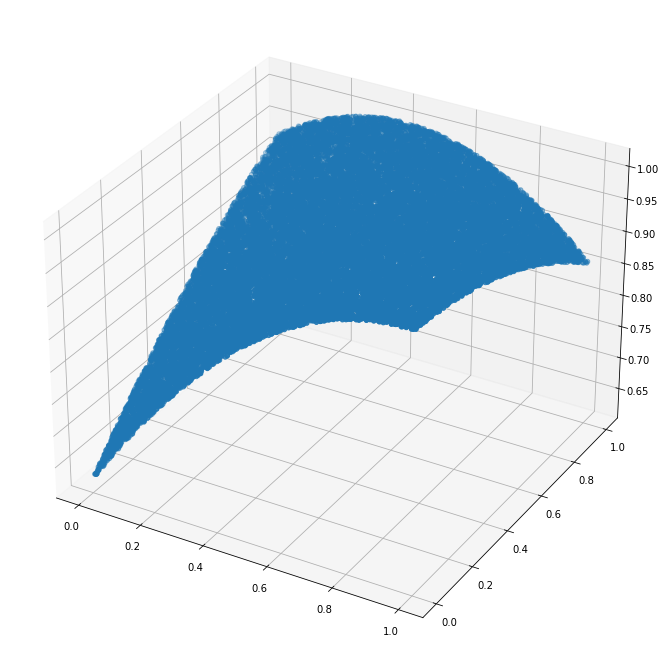

number of nodes
183
Y Min: 0.6291109860286328 Y Max: 0.9999999987602679


In [455]:
# Original values

dim, N, x, u, cs = init(2)
y = oscil(x)
#y = prod(x)
# test and validation divide 95%
trainx, testx, trainy, testy = train_test_split(x, y, test_size = 0.05)
k = node(dim,N)

print('size of x, cs and u')
print(x.shape)
print(cs.shape)
print(u.shape)
print('original function graph(dim<=4)')
graph(dim,x,y)
print('number of nodes')
print(k)
print('Y Min:',np.min(y),'Y Max:',np.max(y))

In [456]:
# Keras fitting sigmoid
model = keras.Sequential([
    keras.layers.Dense(k, activation='sigmoid'),
    keras.layers.Dense(1)
])

# Keras custom activation fitting
def custom_activation(x):
    return x**3

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

model2 = keras.Sequential([
    keras.layers.Dense(k),
    keras.layers.Dense(1)
])
model2.add(Activation(custom_activation, name='SpecialActivation'))

# Keras sigmoid backpropagation
model.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mae']
)

# Keras Custom activation backpropagation
model2.compile(
    loss=tf.keras.losses.mae,
    optimizer='adam',
    metrics=['mae']
)

# Fitting
#model.fit(trainx, trainy, epochs=100)
#model2.fit(trainx, trainy, epochs=100)

NameError: name 'keras' is not defined

In [457]:
start = timeit.default_timer()
# mlpregression with Sigmoid activation adam backpropagation
mlp_reg = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 10000000,activation = 'logistic', n_iter_no_change=100,
                       solver = 'lbfgs', learning_rate_init=0.001,
                       learning_rate ='adaptive', tol=1e-10)
# fitting NN
mlp_reg.fit(trainx, trainy)
#print('convergence: ',len(mlp_reg.loss_curve_))
#print('loss: ', mlp_reg.best_loss_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  1.1588949580327608


In [458]:
start = timeit.default_timer()
# mlpregression with relu activation with changed hyperparameter lbfgs
mlp_reg_re_lb = MLPRegressor(hidden_layer_sizes=(k,),
                       max_iter = 1000000000,activation = 'relu',
                       solver = 'lbfgs',
                       learning_rate_init=0.0005, tol=1e-10)
# fitting NN
mlp_reg_re_lb.fit(trainx, trainy)
print('Convergence: ',mlp_reg_re_lb.n_iter_)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Convergence:  76
Time:  2.635300207999535


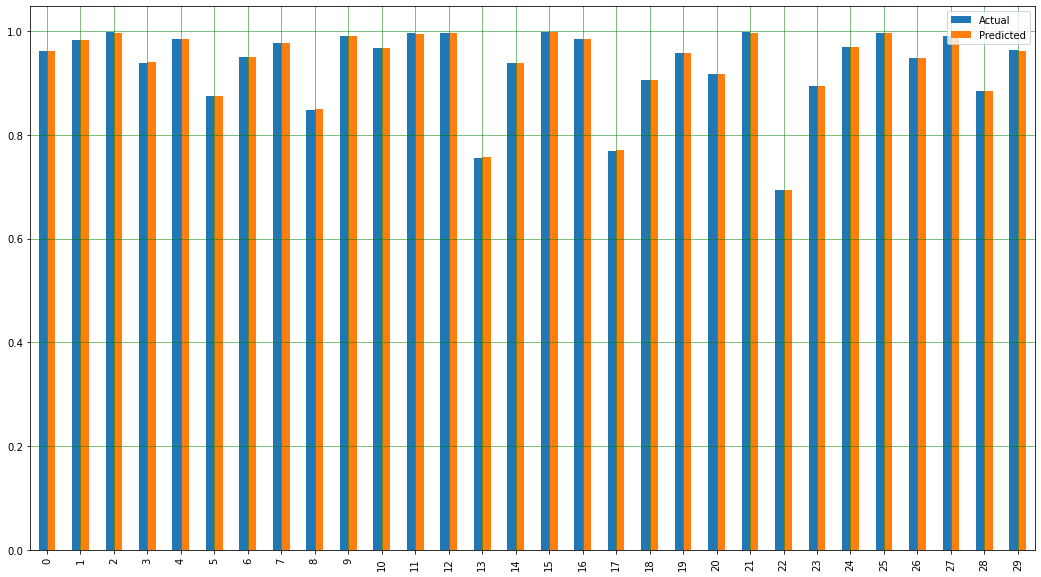

Mean Absolute Error: 0.0006600991074211097
Mean Squared Error: 7.346527136305965e-07
Root Mean Squared Error: 0.0008571188445195896


In [459]:
# Prediction
y_pred = mlp_reg_re_lb.predict(testx)
df_temp = pd.DataFrame({'Actual': testy, 'Predicted': y_pred})
df_temp.head()
# graph of predict and validation
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(18,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# MSE and Loss
print('Mean Absolute Error:', metrics.mean_absolute_error(testy, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testy, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testy, y_pred)))
#plt.plot(mlp_reg_re_lb.loss_curve_)
#plt.title("Loss Curve", fontsize=14)
#plt.xlabel('Iterations')
#plt.ylabel('Cost')
#plt.yscale('log')
plt.show()

In [465]:
print(dim)
sy=symbolicval(dim,0,0)
#print('Analytic_Oscil: ',sy)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg)
sig_lb=sig_integral(dim,0,0)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg_re_lb)
re_lb=re_integral(dim,0,0)
print('Relu_lbsfg: ',digit(sy,re_lb))
print('Sigmoid_lbsfg: ',digit(sy,sig_lb))
#weight_input, weight_output, bias_input, bias_output = tf_coe(model)
#sig_tf=tf_integral(dim,0)
#print('Sigmoid_tensorflow: ',sig_tf)

inval=inpf(1)
sy_f=symbolicval(dim-1,1,inval)
#print('Analytic_fix_Oscil: ',sy_f)
weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg_re_lb)
start = timeit.default_timer()
re_lb_f=re_integral(dim,1,inval)
stop = timeit.default_timer()
print('Relu_lbsfg_fix: ',digit(sy_f,re_lb_f))
print('Time: ', stop - start)  

weight_input, weight_output, bias_input, bias_output = sk_coe(mlp_reg)
start = timeit.default_timer()
sig_lb_f=sig_integral(dim,1,inval)
stop = timeit.default_timer()
print('Sigmoid_lbsfg_fix: ',digit(sy_f,sig_lb_f))
print('Time: ', stop - start)  

2
Relu_lbsfg:  5.0768052218081845
Sigmoid_lbsfg:  3.680238111401377
Relu_lbsfg_fix:  [3.88404337 3.82351424 3.72921774 3.80773453 4.85912983 4.00686917
 3.71977282 4.53743499 4.37287234 4.09945633 4.28848338 3.60986795
 3.7558821  4.81969065 3.71557196 3.60815065 3.80811166 3.6593346
 5.48992655 3.35321561 3.85878676 3.32637137 3.56840351 3.59215321
 4.23036269 3.8685233  3.84974564 3.91220576 3.71426467 3.99641483
 4.43781527 3.64162267 3.74217327 3.75797402 3.90823718 3.78644865
 4.29598111 3.71675184 4.11748405 5.27029527 4.53294144 4.38125212
 3.76870223 3.56919507 3.75466721 4.40010257 3.56758733 3.75687474
 4.21608746 3.99390742 3.75161463 3.31864394 3.87302256 3.89187229
 3.73367216 3.40126502 3.31717457 3.58398632 3.6705734  4.01804681
 3.71521002 3.88719975 5.30164917 4.1029744  4.1567972  3.39242452
 3.87580384 4.79592515 3.34509935 4.00173078 3.6140303  4.1870374
 3.30541996 4.08819584 3.57054996 4.05440927 3.81132497 4.62806918
 3.67872462 4.98174469 3.27292221 3.18696154 3

In [2]:
from sector_1 import I0 # import sector decompositioned function
data = np.loadtxt('sec1.txt') # get the data from text
values = data[:,4] # integrated value with Monte Carlo method
arguments = data[:,:3] # fixed variables values
def vec(x,y,z): # concatenate the single lists
    temp=[]
    for i in range(len(x)):
        temp.append([x[i],y[i],z[i]])
    return np.array(temp)

def sk_coe(mlpr): # get the coefficients of NN
    weight_input = []
    weight_output = mlpr.coefs_[1]
    bias_input = mlpr.intercepts_[0]
    bias_output = mlpr.intercepts_[1]
    for i in range(mlpr.coefs_[0].shape[0]):
        weight_input.append(mlpr.coefs_[0][i:i+1][0])
    return weight_input, weight_output, bias_input, bias_output

def relulb(x,y):
    if weight_input[0][0]!=0:
        t=False
    # mlpregression with relu activation with changed hyperparameter lbfgs
    mlp_sec1 = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'relu',
                           solver = 'lbfgs',alpha=1000,
                           learning_rate_init=0.006, tol=1e-15)
    # fitting NN
    mlp_sec1.fit(x, y)
    mlp_sec1 = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'relu',
                           solver = 'adam', warm_start=t,alpha=1000,
                           learning_rate_init=0.006, tol=1e-15)
    # fitting NN
    mlp_sec1.fit(x, y)
    return mlp_sec1
def relulb2(x,y):
    # mlpregression with relu activation with changed hyperparameter lbfgs
    mlp_sec1 = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'relu',
                           solver = 'lbfgs',alpha=0.001,
                           learning_rate_init=0.006, tol=1e-15)
    # fitting NN
    mlp_sec1.fit(x, y)
    mlp_sec1 = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'relu',
                           solver = 'adam', warm_start=True,alpha=0.001,
                           learning_rate_init=0.003, tol=1e-15)
    # fitting NN
    mlp_sec1.fit(x, y)
    return mlp_sec1
def siglb(x,y):
    # mlpregression with relu activation with changed hyperparameter lbfgs
    mlp_sec1_l = MLPRegressor(hidden_layer_sizes=(k,),
                           max_iter = 1000000000,activation = 'logistic',
                           solver = 'adam',shuffle=True,
                           learning_rate_init=0.0001, tol=1e-15)
    # fitting NN
    mlp_sec1_l.fit(x, y)
    return mlp_sec1_l

def digit(analy,numeric): # get the correct digits
    return -np.log10(abs((analy-numeric)/analy))

def xnorm(x,ymin,ymax): # normalising x value with setted range
    xs = np.empty_like(x)
    xs[:] = x[:]
    for i in range(x.shape[1]):
        xs[:,i]=(ymax-ymin)/(np.max(x[:,i])-np.min(x[:,i]))*(x[:,i]-np.min(x[:,i]))+ymin
    return xs
def inpnorm(inp,mx,ymin,ymax): # input arguments normalisation
    xs=inp
    for i in range(len(inp)):
        xs[i]=(ymax-ymin)/(mx[i]-mx[i+1])*(inp[i]-mx[i+1])+ymin
    return xs
def fnorm(f,ymin,ymax): # normalising y value with setted range
    return (ymax-ymin)/(np.max(f)-np.min(f))*(f-np.min(f))+ymax
def denorm(x,f,I,ymin,ymax): # denormalise the integrated value
    mx=[]
    for i in range(x.shape[1]):
        mx.append(np.max(x[:,i])-np.min(x[:,i]))
    vs=np.prod(mx)
    vss=(ymax-ymin)**x.shape[1]
    return(vs*(np.max(f)-np.min(f)))/(vss*(ymax-ymin))*I+(np.min(f)-(np.max(f)-np.min(f))/(ymax-ymin)*ymin)*vs
def re_integral2(dim,fix,inp):
    def relu(x):
        return np.clip(x,a_min=0.0, a_max=None)
    if fix > 0:
        temp=0
        dim=dim-fix # redefine dimension
        cons=np.dot(inp,weight_input[dim:]) # fixed variable makes to constant value
        print(re_lims2(dim))
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims2(dim)[0][i] # weight input with boundaries
            temp+=re_lims2(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0) # sum all weight input and bias input including boundaries
        result=(bias_output+np.sum(temp*weight_output.T,axis=1)) # add bias output with weight output
        return result
    else:
        poly =[]
        temp=0
        for i in range(len(re_lims(dim)[1])):
            weight=np.array(weight_input[:dim]).T*re_lims(dim)[0][i]
            temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+sum(weight.T))**(dim+1)/np.prod(weight_input,axis=0)
        result=(bias_output+np.sum(temp*weight_output.T[0]))[0]
        return result

In [8]:
low = np.array([0,0,0,-30,-30,-30]) # set the minimum range of random variables
high = np.array([1,1,1,-3,-3,-3]) # set the maximum range of random variables
vari2 = np.random.random(size=(300_000,6)) # set the size of random value
vari2 = vari2*(high-low)+low # make the random variables to setted range
#N=100000 # size of variables
#x1=np.linspace(0,1,N) # uniform variables
#x2=np.linspace(0,1,N) # uniform variables
#x3=np.linspace(0,1,N) # uniform variables
#ar1 = np.linspace(-3, -30, N) # uniform variables
#ar2 = np.linspace(-3, -30, N) # uniform variables
#ar3 = np.linspace(-3, -30, N) # uniform variables
#xx=vec(x1,x2,x3)
#ar=vec(ar1,ar2,ar3)
#vari2=np.concatenate((xx,ar),axis=1)


Y=[]
Y2=[]
X=vari2
mx=[np.max(X[:,3]),np.min(X[:,3]),np.max(X[:,4]),np.min(X[:,4]),np.max(X[:,5]),np.min(X[:,5])] # maximum and minimum value of fixed variables
for i in range(X.shape[0]):
    Y2.append(I0(X[i,:3],X[i,3:],[])/(I0(np.array([1/2]*(3)),X[i,3:],[]))) # make hypercube
    Y.append(I0(X[i,:3],X[i,3:],[])) # normal Y values
Y=np.array(Y)
Y2=np.array(Y2)

print(len(Y))

dmin, dmax = Y.min(),Y.max() 
dmin2, dmax2 = Y2.min(),Y2.max()
dmean, dstd = Y.mean(),Y.std()
dmean2, dstd2 = Y2.mean(),Y2.std()
#plt.hist(Y2)
#plt.yscale('log')

imean = np.array([0.5,0.5,0.5,-16.5,-16.5,-16.5]) # mean of x values
iscale = np.array([1,1,1,27,27,27]) # scale of x values
normalised_val=[]
for i in range(arguments.shape[0]):
    normalised_val.append(values[0]/(I0(np.array([1/2]*(3)),arguments[0],[])))

print(np.max(values)/np.min(values))
plt.plot(range(len(values)),values)
plt.show()
print(np.max(normalised_val)/np.min(normalised_val))
plt.plot(range(len(normalised_val)),normalised_val)
plt.show()

300000


NameError: name 'argument' is not defined

7.604289810616983


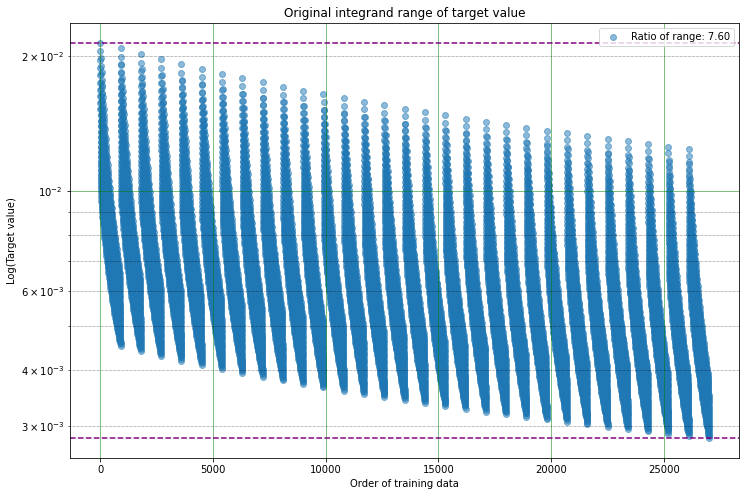

2.841887283733788


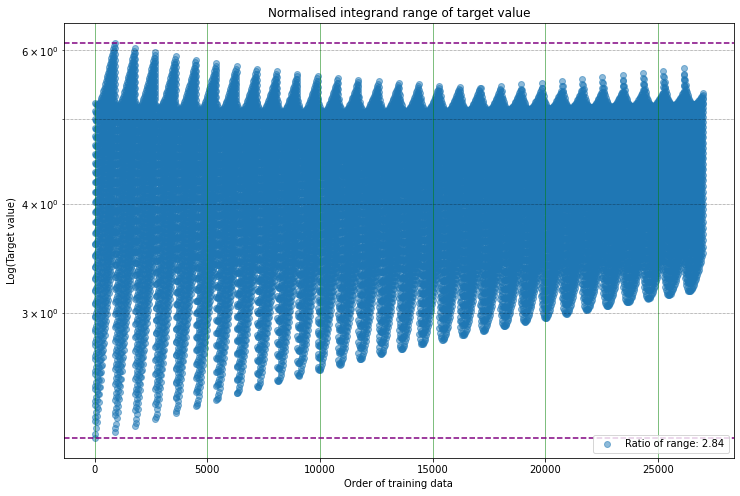

In [16]:
normalised_val=[]
for i in range(arguments.shape[0]):
    normalised_val.append(values[i]/(I0(np.array([1/2]*(3)),arguments[i],[])))

print(np.max(values)/np.min(values))
plt.figure(figsize=(12, 8))
plt.scatter(range(len(values)),values,alpha=0.5,label='Ratio of range: 7.60')
plt.axhline(y=np.max(values),color='purple',linestyle='--',lw=1.5)
plt.axhline(y=np.min(values),color='purple',linestyle='--',lw=1.5)
plt.yscale('log')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.legend(loc='upper right')
plt.title('Original integrand range of target value')
plt.xlabel('Order of training data')
plt.ylabel('Log(Target value)')
plt.show()
print(np.max(normalised_val)/np.min(normalised_val))
plt.figure(figsize=(12, 8))
plt.scatter(range(len(normalised_val)),normalised_val,alpha=0.5,label='Ratio of range: 2.84')
plt.axhline(y=np.max(normalised_val),color='purple',linestyle='--',lw=1.5)
plt.axhline(y=np.min(normalised_val),color='purple',linestyle='--',lw=1.5)
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.yscale('log')
plt.legend(loc='lower right')
plt.title('Normalised integrand range of target value')
plt.xlabel('Order of training data')
plt.ylabel('Log(Target value)')
plt.show()

In [160]:
print(X)

print(Y)


[[ 4.40457723e-01  2.12520902e-01  1.08560629e-01 -1.44440830e+01
  -1.48992845e+01 -1.13399303e+01]
 [ 2.31336104e-01  1.50091983e-02  6.04920143e-01 -1.69889057e+01
  -3.81016285e+00 -6.33541163e+00]
 [ 2.17199721e-01  5.50663300e-01  6.37604694e-01 -1.31990590e+01
  -6.75391610e+00 -2.70298088e+01]
 ...
 [ 3.38645931e-01  5.60369172e-01  8.05571277e-02 -3.05879422e+00
  -2.28968294e+01 -6.76586910e+00]
 [ 7.65999091e-01  9.94567844e-01  3.68150089e-01 -6.84658633e+00
  -2.82070894e+01 -1.72870311e+01]
 [ 4.02501914e-01  9.20133794e-01  8.16094165e-01 -1.21078626e+01
  -2.57814615e+01 -3.09485041e+00]]
[0.01457479 0.02832923 0.00172797 ... 0.00294658 0.00028463 0.00059426]


In [16]:
k = 70 # set the node number
dim = 6 # set the dimension

a1=relulb(Xn,Yn2) # run NN Relu-lbfgs
#a2=relulb2(Xn,Yn2) # run NN Relu-lbfgs

In [15]:
normalised_val=values[0]/(I0(np.array([1/2]*(3)),arguments[0],[])) # Hypercube value of answer

inp=np.loadtxt('sec1.txt')[0,:3] # get the input value
inp=(inp-imean[3:])/iscale[3:] # normalise the input value
#inp=inpnorm(inp,mx,0,1)
print(inp)
weight_input, weight_output, bias_input, bias_output = sk_coe(a1) # get the weight and bias values
ans=re_integral2(6,3,inp)[0]*dstd2+dmean2 # integral of relu  and denormalising
ans2=denorm(X,Y,ans,0,1) # denormalising of paper method
print(ans)
print(re_integral(6,3,inp)[0]*dstd2+dmean2)
#print(ans2)
print('normalised_val',normalised_val)
#print(data[-1,4])
#print(digit(normalised_val,ans))
print(weight_input)

[0.49962963 0.49925926 0.49888889]
(array([[-0.5, -0.5, -0.5],
       [-0.5, -0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [-0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5],
       [ 0.5, -0.5,  0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5]]), [-1, 1, 1, -1, 1, -1, -1, 1])
nan
nan
normalised_val 2.1543830293842534
[array([-9.70022153e-150, -7.21042063e-061, -4.77456566e-044,
       -5.71943268e-029, -3.09027219e-005,  2.29014936e-005,
       -2.55848123e-150,  1.90556198e-007,  5.40784434e-007,
       -4.73733220e-007, -2.69474274e-006, -1.92695570e-014,
        8.57906226e-006,  2.98755797e-061, -1.55297042e-149,
       -1.64329995e-149,  8.42476616e-031,  2.71581786e-150,
        1.78884595e-149, -5.06909977e-150, -1.19030390e-028,
       -1.17954613e-024,  2.86865585e-149,  8.24630982e-150,
       -1.01993347e-010, -3.13243453e-021,  1.02690628e-149,
       -2.56034571e-149, -1.77160144e-006,  2.24324056e-149,
        1.08042173e-006,  1.69468164e-150,  5.08579281e-005,
  

<ipython-input-13-720556bc152c>:95: RuntimeWarning: invalid value encountered in true_divide
  temp+=re_lims2(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0) # sum all weight input and bias input including boundaries
<ipython-input-2-11fbd7fb39ad>:208: RuntimeWarning: invalid value encountered in true_divide
  temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0) # sum all weight input and bias input including boundaries


In [174]:
normalised_val=values[0]/(I0(np.array([1/2]*(3)),arguments[0],[])) # Hypercube value of answer

inp=np.loadtxt('sec1.txt')[0,:3] # get the input value
inp=(inp-imean[3:])/iscale[3:] # normalise the input value
#inp=inpnorm(inp,mx,0,1)
print(inp)
weight_input, weight_output, bias_input, bias_output = sk_coe(a2) # get the weight and bias values
ans=re_integral(6,3,inp)[0]#*dstd2+dmean2 # integral of relu  and denormalising
ans2=denorm(X,Y,ans,0,1) # denormalising of paper method
print(ans)
#print(ans2)
#print('normalised_val',normalised_val)
#print(data[-1,4])
#print(digit(normalised_val,ans))
print(dstd2,dmean2)
print(weight_input)

[0.49962963 0.49925926 0.49888889]
nan
14.05811545661375 4.184612797055429
[array([-4.73963045e-002, -1.33426957e-001, -5.33816491e-001,
       -1.30133220e-001,  3.17693386e-001,  1.36154962e-001,
       -1.58666151e+000,  4.53173027e-001, -1.32753814e+000,
       -1.49738032e-001,  8.36153078e-001,  4.18041977e-001,
        4.69371522e-001, -4.00052998e-001, -6.84761003e-317,
       -1.55570562e+000,  1.46218926e-001,  4.97010035e-001,
        5.06997968e-002,  1.31402838e+000, -1.15364522e+000,
        9.94541307e-001, -1.35264574e+000, -1.92463464e+000,
       -1.83114713e-001, -1.41727765e+000, -9.63067090e-002,
        4.98239987e-001, -8.66126699e-001,  2.01499432e-001,
       -7.51315963e-002, -2.60730645e-001,  1.09301308e-001,
       -8.51390689e-002, -1.87074455e-001,  7.28103307e-317,
       -7.54151867e-002,  8.25701425e-002, -7.83355750e-001,
       -3.33414943e-001]), array([ 1.39296613e+000,  1.85282033e+000, -4.70587725e+000,
        1.93453842e+000,  2.40792590e+000, 

<ipython-input-43-11fbd7fb39ad>:208: RuntimeWarning: invalid value encountered in true_divide
  temp+=re_lims(dim)[1][i]*1/np.prod(np.arange(dim+2)[1:])*relu(bias_input+cons+sum(weight.T))**(dim+1)/np.prod(weight_input[:dim],axis=0) # sum all weight input and bias input including boundaries


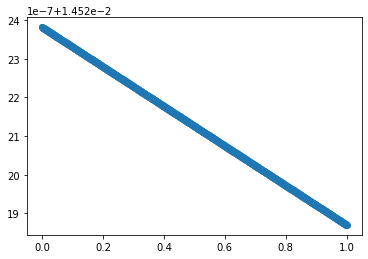

0.014522381861873768


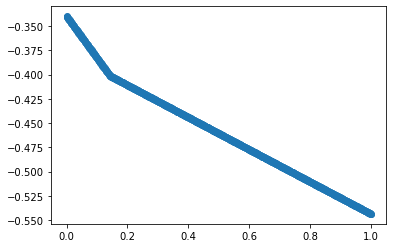

-0.33989195664396454


In [170]:
xx = np.empty(shape=(1000,6))
xx[:,0] = np.linspace(0,1,1000)
xx[:,1:] = [0.5,0.6,1,1,1]


y=a1.predict(xx)
plt.scatter(xx[:,0],y)
plt.show()
print(np.max(y))
y2=a2.predict(xx)
plt.scatter(xx[:,0],y2)
plt.show()
print(np.max(y2))

In [48]:
start = timeit.default_timer()
RL_k={}

inp=np.loadtxt('sec2.txt')[-1,:3]

dim = 6
Kr=[30,100,200,300,500,1000,1500]


for i in range(len(Kr)):
    temp=[]
    k=0
    for j in range(5):
        k=Kr[i]
        weight_input, weight_output, bias_input, bias_output = sk_coe(relulb(X,Y2))
        ans=re_integral(6,3,inp)[0]
        temp.append(digit(normalised_val ,ans)) 
    RL_k[k]=temp
    print(i)
stop = timeit.default_timer()
print('Time: ', stop - start)  

/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


1


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


2


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWa

4


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


KeyboardInterrupt: 

In [52]:
start = timeit.default_timer()
RL_n={}

inp=np.loadtxt('sec2.txt')[-1,:3]
k=150
dim = 6
N=[1000,5000,10000,50000,100000,500000]


for i in range(len(Kr)):
    low = np.array([0,0,0,-30,-30,-30])
    high = np.array([1,1,1,-3,-3,-3])
    vari2 = np.random.random(size=(N[i],6))
    vari2 = vari2*(high-low)+low
    X=vari2
    Y2=[]
    for k in range(X.shape[0]):
        Y2.append(I0(X[k,:3],X[k,3:],[])/(I0(np.array([1/2]*(3)),X[k,3:],[])))
    Y2=np.array(Y2)
    temp=[]

    for j in range(5):
        weight_input, weight_output, bias_input, bias_output = sk_coe(relulb(X,Y2))
        ans=re_integral(6,3,inp)[0]
        temp.append(digit(normalised_val ,ans)) 
    RL_n[N[i]]=temp
    print(i)
stop = timeit.default_timer()
print('Time: ', stop - start)  

/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWa

0


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWa

1


/Users/minwookim/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


KeyboardInterrupt: 

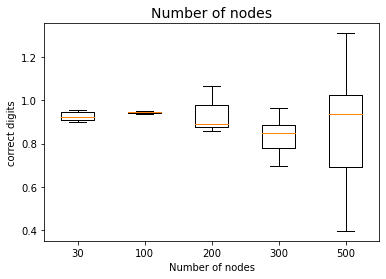

In [49]:
fig, ax = plt.subplots()
ax.boxplot(RL_k.values())
ax.set_xticklabels(RL_k.keys())
plt.title("Number of nodes", fontsize=14)
plt.xlabel('Number of nodes')
plt.ylabel('correct digits')
plt.show()

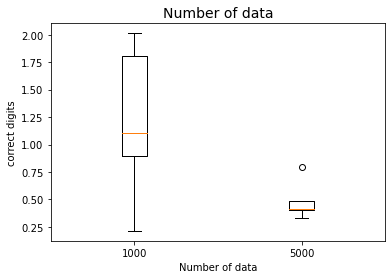

In [53]:
fig, ax = plt.subplots()
ax.boxplot(RL_n.values())
ax.set_xticklabels(RL_n.keys())
plt.title("Number of data", fontsize=14)
plt.xlabel('Number of data')
plt.ylabel('correct digits')
plt.show()

In [48]:
start = timeit.default_timer()
RL_k={}
SL_k={}
inp=fix[-1]#np.matrix([-30.000000000000000 ,-29.899999999999999 ,-29.800000000000001 ,1.000000000000000 ])
dim=7
Kr=[30,60,140,210,250]
Ks=[300,500,700,900,1000]

N=100000
s12 = np.array(np.linspace(-3.01, -30.0, N))
s14 = np.array(np.linspace(-3.02, -29.9, N))
mh2 = np.array(np.linspace(-3.03, -29.8, N))
mt2 = np.array([1] * N)
fix=vec(s12, s14, mh2, mt2)
vari = np.random.random((N,dim-fix.shape[1]))
Y=[]
X=np.concatenate((vari,fix),axis=1)
for i in range(len(vari)):
    Y.append(I0(vari[i],fix[i],0)/(I0(np.array([1/2]*(dim-fix.shape[1])),fix[i],0)))
Y=np.array(Y)

for i in range(len(Kr)):
    temp=[]
    temp2=[]
    k=0
    for j in range(3):
        k=Kr[i]
        weight_input, weight_output, bias_input, bias_output = sk_coe(relulb(X,Y))
        ans=re_integral(7,4,inp)[0]
        ans=ans*I0(np.array([1/2]*(dim-fix.shape[1])),inp,0)
        temp.append(digit(6.12601731250704030e-04 ,ans)) 
    RL_k[k]=temp
    for j in range(3):
        k=Ks[i]
        weight_input, weight_output, bias_input, bias_output = sk_coe(siglb(X,Y))
        ans2=sig_integral(7,4,inp)[0]
        ans2=ans2*I0(np.array([1/2]*(dim-fix.shape[1])),inp,0)
        temp2.append(digit(6.12601731250704030e-04 ,ans2))
    SL_k[k]=temp2
    print(i)
print('Time: ', stop - start)  

0
1
2
3
4
Time:  -64806.122577457994


In [49]:
start = timeit.default_timer()
RL_n={}
SL_n={}
inp=fix[-1]#np.matrix([-30.000000000000000 ,-29.899999999999999 ,-29.800000000000001 ,1.000000000000000 ])
dim=7
nr=[5000,15000,100000,200000,500000]
ns=[5000,8000,10000,15000,30000]
k=200

for i in range(len(nr)):
    temp=[]
    temp2=[]
    N=nr[i]
    s12 = np.array(np.linspace(-3.01, -30.0, N))
    s14 = np.array(np.linspace(-3.02, -29.9, N))
    mh2 = np.array(np.linspace(-3.03, -29.8, N))
    mt2 = np.array([1] * N)
    fix=vec(s12, s14, mh2, mt2)
    vari = np.random.random((N,dim-fix.shape[1]))
    Y=[]
    X=np.concatenate((vari,fix),axis=1)
    for j in range(len(vari)):
        Y.append(I0(vari[i],fix[i],0)/(I0(np.array([1/2]*(dim-fix.shape[1])),fix[i],0)))
    Y=np.array(Y)
    for l in range(3):
        weight_input, weight_output, bias_input, bias_output = sk_coe(relulb(X,Y))
        ans=re_integral(7,4,inp)[0]
        ans=ans*I0(np.array([1/2]*(dim-fix.shape[1])),inp,0)
        temp.append(digit(6.12601731250704030e-04 ,ans)) 
    RL_n[N]=temp   
    
    N=ns[i]
    s12 = np.array(np.linspace(-3.01, -30.0, N))
    s14 = np.array(np.linspace(-3.02, -29.9, N))
    mh2 = np.array(np.linspace(-3.03, -29.8, N))
    mt2 = np.array([1] * N)
    fix=vec(s12, s14, mh2, mt2)
    vari = np.random.random((N,dim-fix.shape[1]))
    Y=[]
    X=np.concatenate((vari,fix),axis=1)
    for j in range(len(vari)):
        Y.append(I0(vari[i],fix[i],0)/(I0(np.array([1/2]*(dim-fix.shape[1])),fix[i],0)))
    Y=np.array(Y)     
    for l in range(3):    
        weight_input, weight_output, bias_input, bias_output = sk_coe(siglb(X,Y))
        ans2=sig_integral(7,4,inp)[0]
        ans2=ans2*I0(np.array([1/2]*(dim-fix.shape[1])),inp,0)
        temp2.append(digit(6.12601731250704030e-04 ,ans2))
    SL_n[N]=temp2
    print(i)
print('Time: ', stop - start)  

0
1
2
3
4
Time:  -76529.478779583


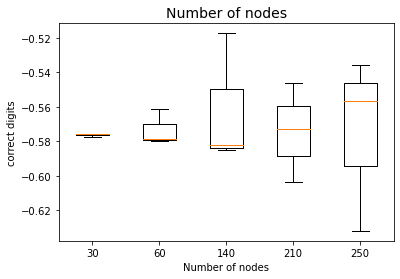

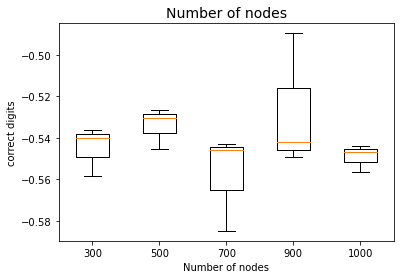

In [50]:
fig, ax = plt.subplots()
ax.boxplot(RL_k.values())
ax.set_xticklabels(RL_k.keys())
plt.title("Number of nodes", fontsize=14)
plt.xlabel('Number of nodes')
plt.ylabel('correct digits')
plt.show()

fig, ax = plt.subplots()
ax.boxplot(SL_k.values())
ax.set_xticklabels(SL_k.keys())
plt.title("Number of nodes", fontsize=14)
plt.xlabel('Number of nodes')
plt.ylabel('correct digits')
plt.show()

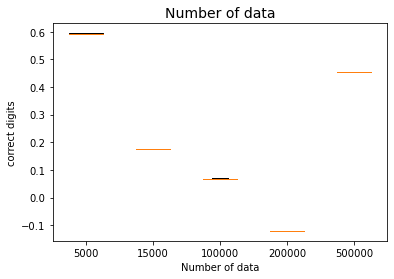

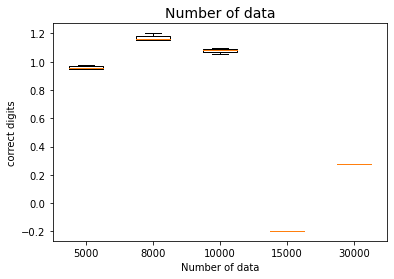

In [51]:
fig, ax = plt.subplots()
ax.boxplot(RL_n.values())
ax.set_xticklabels(RL_n.keys())
plt.title("Number of data", fontsize=14)
plt.xlabel('Number of data')
plt.ylabel('correct digits')
plt.show()

fig, ax = plt.subplots()
ax.boxplot(SL_n.values())
ax.set_xticklabels(SL_n.keys())
plt.title("Number of data", fontsize=14)
plt.xlabel('Number of data')
plt.ylabel('correct digits')
plt.show()

In [28]:
d = { 1:'a'}

def f(dic):
    newdic = dict()
    newdic.update(dic)
    newdic[2] = 'b'
    return newdic

f(d),d

({1: 'a', 2: 'b'}, {1: 'a'})

(10, 2)
[3.26880468e-06 8.88333333e-07]


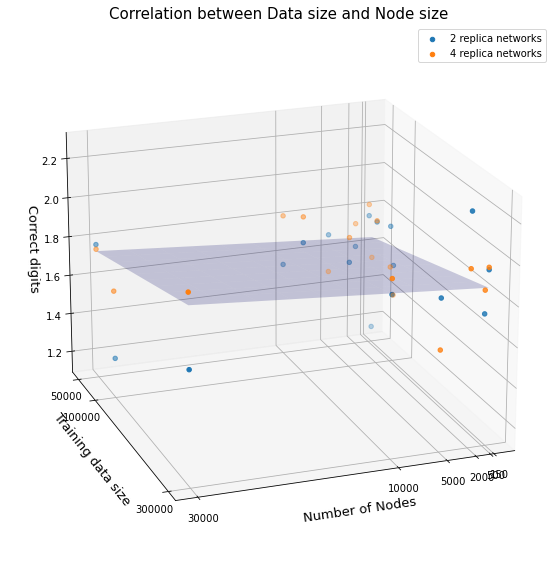

In [84]:
from sklearn import linear_model
node=[150,500,2000,5000,10000,30000]
data=[50000,100000,300000]
x=[[150,50000],[150,100000],[150,300000],
   [500,50000],[500,100000],[500,300000],
   [2000,50000],[2000,100000],[2000,300000],
   [5000,50000],[5000,100000],[5000,300000],
   [10000,50000],[10000,100000],[10000,300000],
   [30000,50000],[30000,100000],[30000,300000]]
cd2=[1.168,1.594,1.959,
     1.765,1.801,1.746,
    1.610,1.832,2.252,
    1.689,1.639,1.851,
    1.561,1.770,1.898,
    1.781,1.293,1.664]
cd4=[1.541,1.438,1.971,
    1.824,1.588,1.862,
    1.731,1.838,1.975,
    1.494,1.768,1.597,
    1.817,1.903,1.975,
    1.757,1.639,2.031]
xx2=[[150,50000,1.168],[150,100000,1.594],[150,300000,1.959],
   [500,50000,1.765],[500,100000,1.801],[500,300000,1.746],
   [2000,50000,1.610],[2000,100000,1.832],[2000,300000,2.252],
   [5000,50000,1.689],[5000,100000,1.639],[5000,300000,1.851],
   [10000,50000,1.561],[10000,100000,1.770],[10000,300000,1.898],
   [30000,50000,1.781],[30000,100000,1.293],[30000,300000,1.664]]
xx4=[[150,50000],[150,100000],[150,300000],
   [500,50000],[500,100000],[500,300000],
   [2000,50000],[2000,100000],[2000,300000],
   [5000,50000],[5000,100000],[5000,300000],
   [10000,50000],[10000,100000],[10000,300000],
   [30000,50000],[30000,100000],[30000,300000]]
xrange=np.linspace(150,30000,num=10)
yrange=np.linspace(50000,300000,num=10)
#xy=np.concatenate((xrange,yrange),axis=1)
xy = np.array([[a1, b1] for (a1, b1) in zip(xrange, yrange)])
print(xy.shape)


lr = linear_model.LinearRegression()
model = lr.fit(x, cd2)
model2 = lr.fit(x, cd4)
X, Y=np.meshgrid(xrange,yrange)
Z=X*model.coef_[0]+Y*model.coef_[1]+model.intercept_
Z2=X*model2.coef_[0]+Y*model2.coef_[1]+model2.intercept_

print(model.coef_)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x1=np.array([j[0] for j in x])
x2=np.array([j[1] for j in x])
ax.plot_surface(X,Y,Z,rstride=1, cstride=1, alpha = 0.2, color='navy')
#ax.plot_surface(X,Y,Z2,rstride=1, cstride=1, alpha = 0.2, color='orange')
ax.scatter(x1, x2, cd2,label='2 replica networks')
ax.scatter(x1, x2, cd4,label='4 replica networks')
ax.set_xticks(node)
ax.set_yticks(data)
ax.view_init(20, 70)
ax.set_xlabel('Number of Nodes',fontsize=13)
ax.set_ylabel('Training data size',fontsize=13)
ax.set_zlabel('Correct digits',fontsize=13)
ax.set_title('Correlation between Data size and Node size',fontsize=15)
ax.legend(loc='upper right')
fig.set_size_inches(15, 10)




plt.show()

[[-100000.]
 [ -50000.]
 [ 150000.]
 [-100000.]
 [ -50000.]
 [ 150000.]
 [-100000.]
 [ -50000.]
 [ 150000.]
 [-100000.]
 [ -50000.]
 [ 150000.]
 [-100000.]
 [ -50000.]
 [ 150000.]
 [-100000.]
 [ -50000.]
 [ 150000.]]
[-100000.0, -50000.00000000004, 150000.0, -99999.99999999999, -50000.0, 150000.0, -99999.99999999999, -49999.99999999999, 149999.99999999997, -100000.00000000001, -50000.0, 150000.00000000003, -100000.0, -49999.99999999999, 150000.0, -99999.99999999999, -50000.0, 150000.0]
1.198333333333333e-06
8.883333333333337e-07


<ipython-input-88-fb600ebeadbe>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pclist.append(np.float(pc[i]))


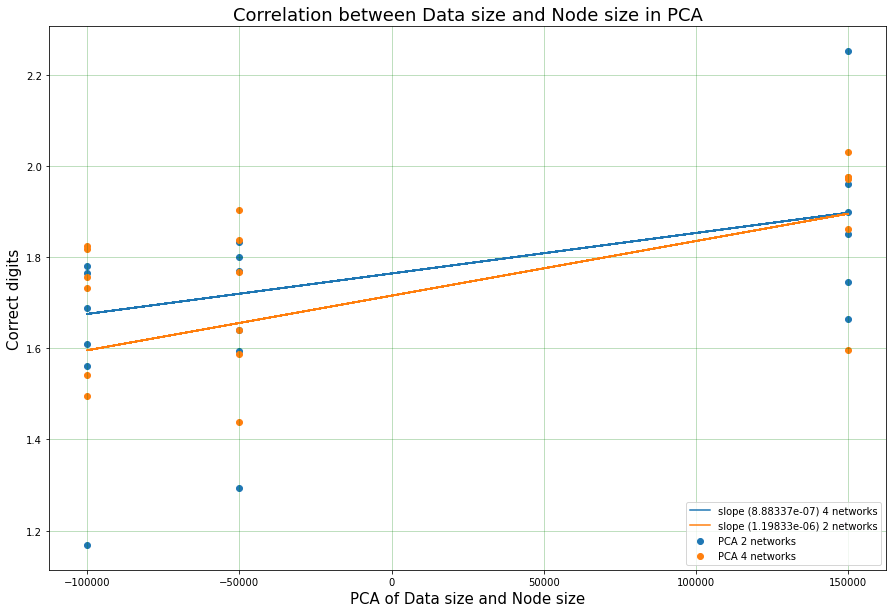

In [88]:
from sklearn.decomposition import PCA
import scipy
pca = PCA(n_components=1)
pc = pca.fit_transform(x)
print(pc)
pclist=[]
for i in range(len(pc)):
    pclist.append(np.float(pc[i]))
print(pclist)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pclist, cd2)
slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(pclist, cd4)
cd2y=pc*slope+intercept
cd4y=pc*slope2+intercept2
print(slope)
print(slope2)
fig = plt.figure(figsize=(15, 10))
plt.scatter(pc,cd2,label='PCA 2 networks')
plt.plot(pc,cd4y,label='slope (8.88337e-07) 4 networks')
plt.plot(pc,cd2y,label='slope (1.19833e-06) 2 networks')
plt.scatter(pc,cd4,label='PCA 4 networks')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green',alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black',alpha=0.5)
plt.legend(loc='lower right')
plt.xlabel('PCA of Data size and Node size',fontsize=15)
plt.ylabel('Correct digits',fontsize=15)
plt.title('Correlation between Data size and Node size in PCA',fontsize=18)
plt.show()

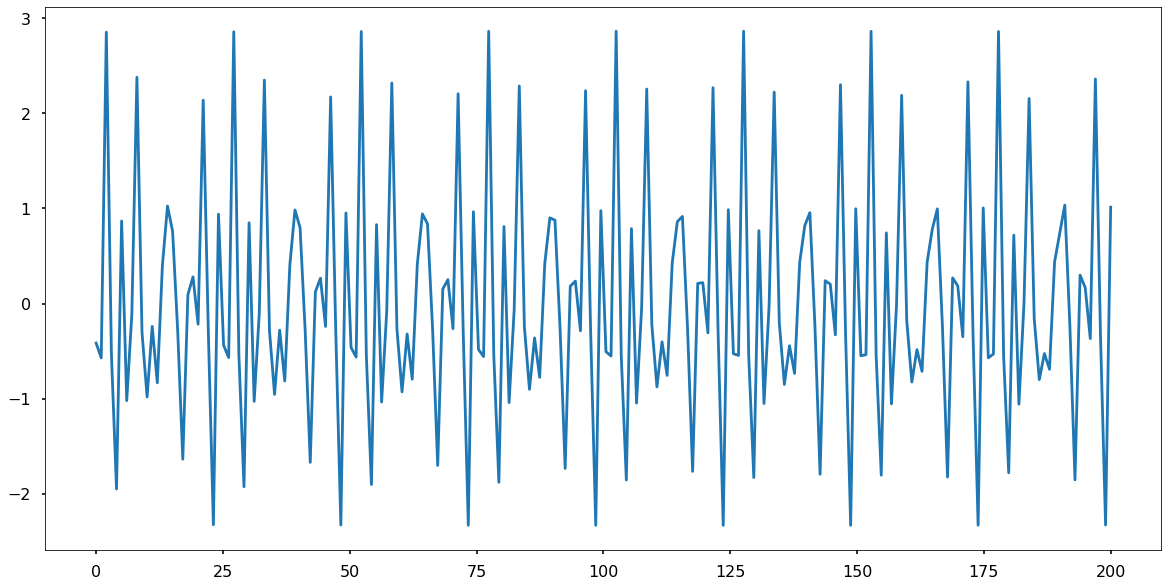

In [115]:
from scipy.fftpack import fftfreq
import pandas as pd
x=np.linspace(0,200,num=200)
y=np.sin(x)+np.cos(2*x+2)+np.sin(x*4)
fig = plt.figure(figsize=(20, 10))
plt.plot(x,y)

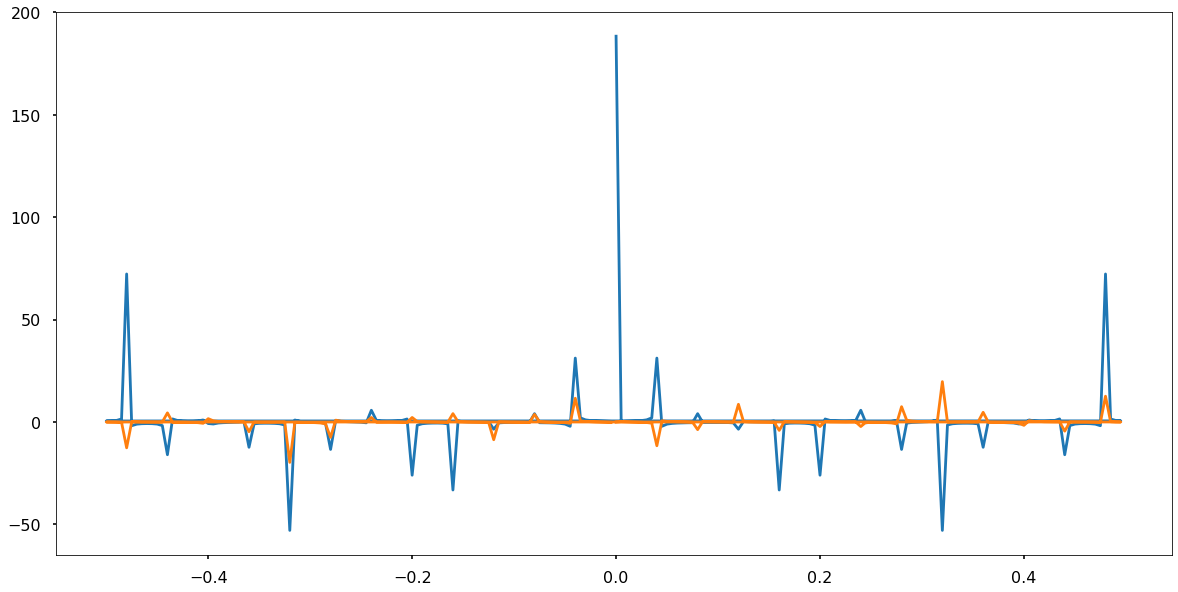

In [116]:
import matplotlib.pyplot as plt
t = x
sp = np.fft.fft(abs(y))
freq = np.fft.fftfreq(t.shape[-1])
fig = plt.figure(figsize=(20, 10))
plt.plot(freq, sp.real, freq, sp.imag)

plt.show()

In [105]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

In [106]:
def FFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey FFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)
        
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X

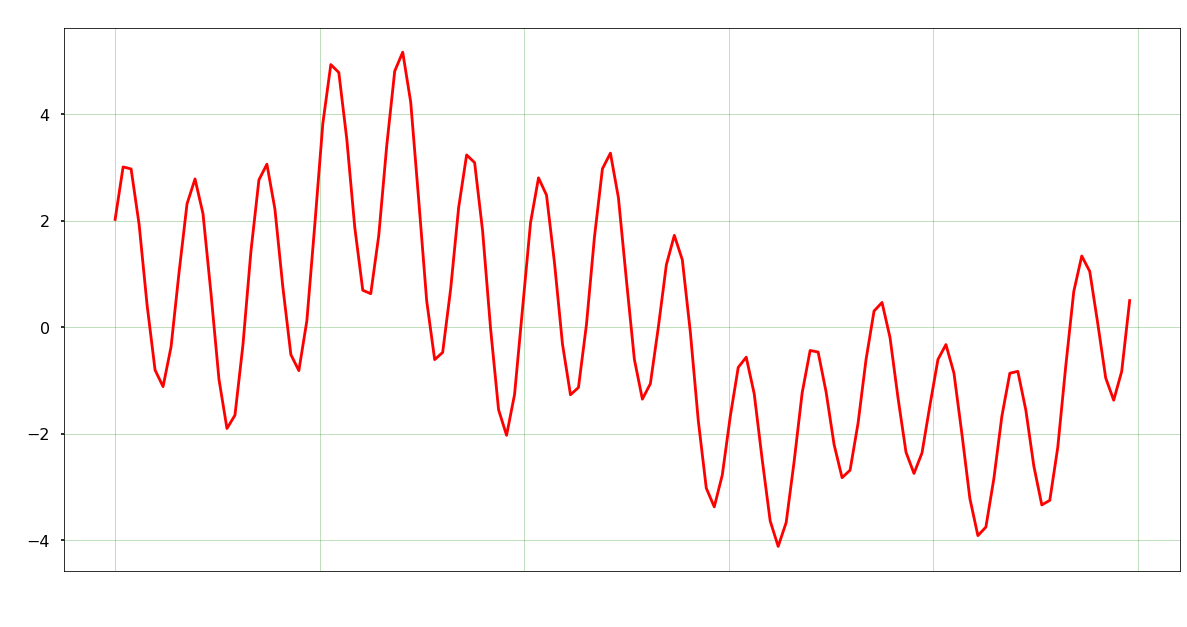

In [140]:
# sampling rate
sr = 128
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 2*np.sin(2*np.pi*freq*t)

freq = 4
x += np.cos(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(4*np.pi*freq*t+2)

freq = 10   
x += 2* np.cos(3*np.pi*freq*t+5)

fig = plt.figure(figsize=(20, 10))
plt.plot(t, x, 'r')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green',alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black',alpha=0.5)
plt.title('Cogging torque test',color='w',fontsize=20)
plt.ylabel('Amplitude',color='w',fontsize=15)
plt.xlabel('Round',color='w',fontsize=15)
plt.tick_params(axis='x', colors='w')

plt.show()

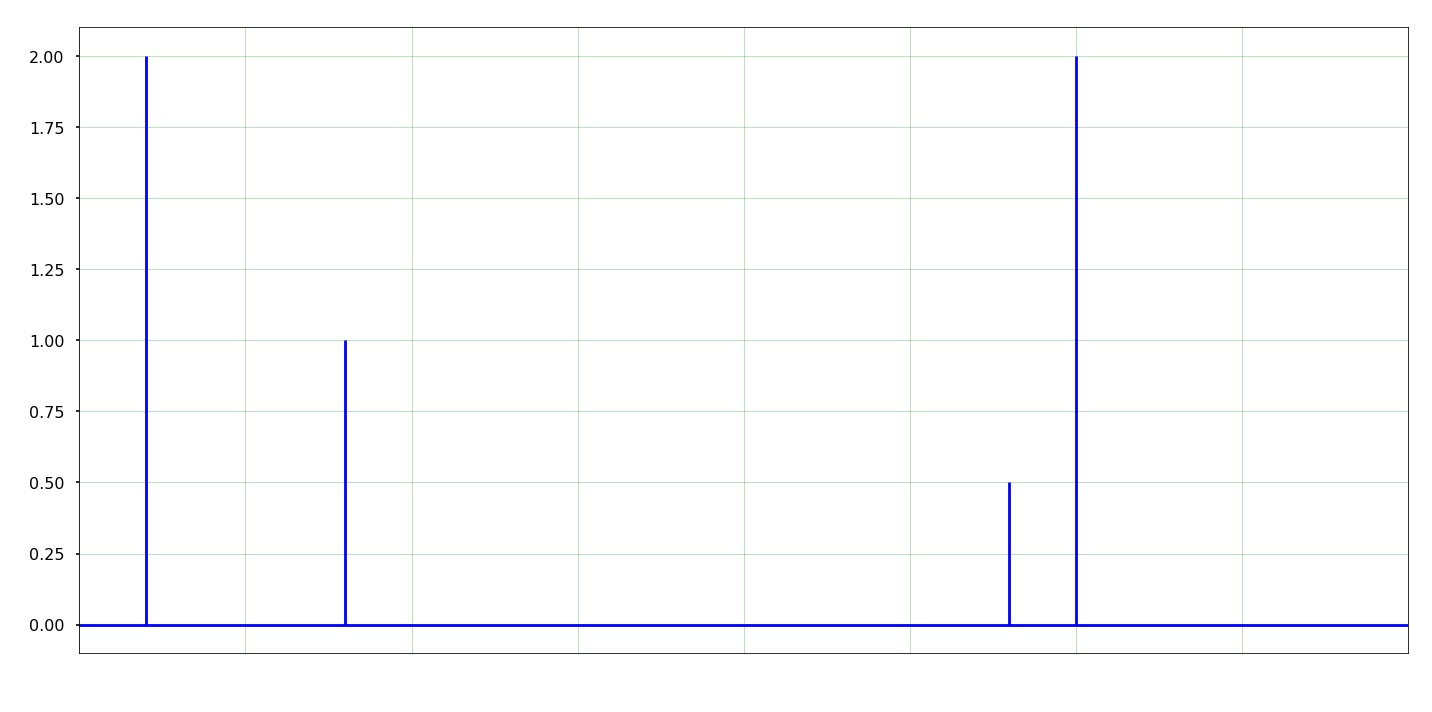

In [138]:
X=FFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

#plt.figure(figsize = (12, 6))
#plt.subplot(121)
#plt.stem(freq, abs(X), 'b', \
#         markerfmt=" ", basefmt="-b")
#plt.xlabel('Freq (Hz)')
#plt.ylabel('FFT Amplitude |X(freq)|')

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

fig = plt.figure(figsize=(20, 10))
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)',color='w')
plt.ylabel('Normalized FFT Amplitude |X(freq)|',color='w')
plt.title('Applied Normalized FFT',color='w')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green',alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black',alpha=0.5)
plt.tick_params(axis='x', colors='w')
plt.xlim(0,20)
plt.tight_layout()
plt.show()

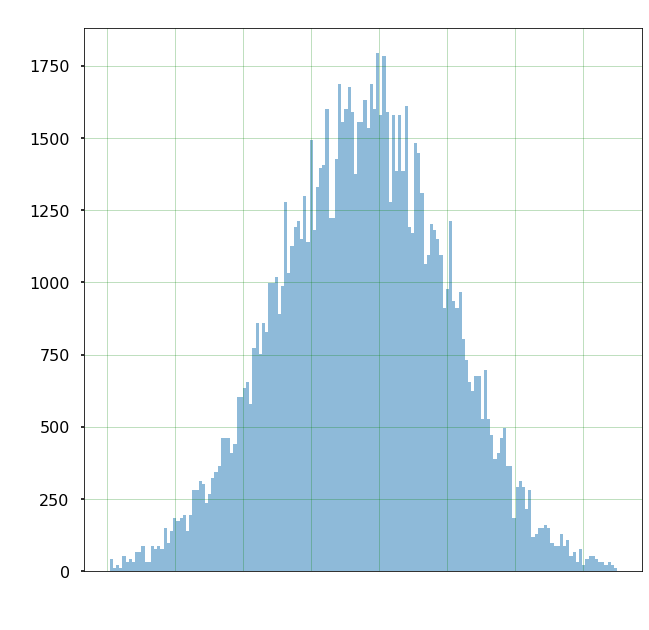

In [157]:
sigma = 3
dp = 3.900
tol_dpmax = 2.7015
tol_dpmin = 2.7000

ntest = 10000
samp = scipy.stats.truncnorm.rvs((tol_dpmin-dp)/sigma,(tol_dpmax-dp)/sigma, size=ntest)
# scale & translate to original (non-normalized) location
samp_non_norm = (samp*sigma)+dp


import matplotlib.pyplot as plt
#plt.hist(samp_non_norm, 100)

dp_new = (tol_dpmin + tol_dpmax)/2
dp_std = (tol_dpmax - dp_new)/sigma  # top boundary is "three sigmas" from center

ntest = 10000
samp = scipy.stats.truncnorm.rvs((tol_dpmin-dp_new)/dp_std,(tol_dpmax-dp_new)/dp_std, size=ntest)
# scale & translate to original (non-normalized) location
samp_non_norm = (samp*dp_std)+dp_new

fig = plt.figure(figsize=(10, 10))
plt.hist(samp_non_norm, bins=160, density=True, alpha=0.5)
plt.xlabel('Tolerance',color='w')
plt.title('Monte Carlo Tolerance cal',color='w')
plt.ylabel('Accumulated',color='w')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green',alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black',alpha=0.5)
plt.tick_params(axis='x', colors='w')